**Loading the dataset**

In [3]:
!pip install nnfs

In [4]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
nnfs.init()

**Plotting the dataset**

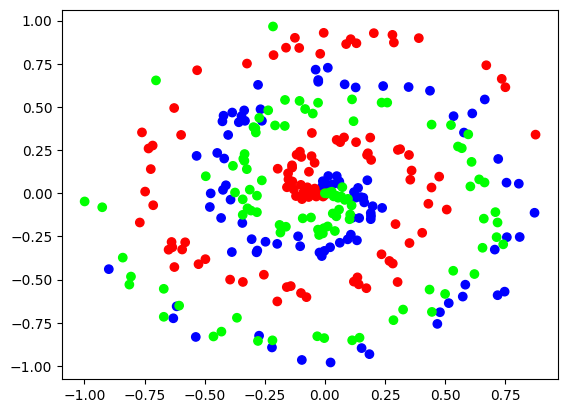

In [7]:
import matplotlib.pyplot as plt
X,y=spiral_data(samples=100,classes=3)
plt.scatter(X[:,0],X[:,1],c=y,cmap='brg')
plt.show()

**CREATING LAYERS: FORWARD AND BACKWARD PASS**

In [8]:
# Dense layer
class Layer_Dense:
    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from input ones, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

    # Backward pass
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

**RELU ACTIVATION: FORWARD AND BACKWARD PASS**

In [9]:
# ReLU activation
class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

    # Backward pass
    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let’s make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

**SOFTMAX ACTIVATION: FORWARD PASS**

In [10]:
# Softmax activation
class Activation_Softmax:
 # Forward pass
 def forward(self, inputs):
 # Get unnormalized probabilities
  exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
 # Normalize them for each sample
  probabilities = exp_values / np.sum(exp_values, axis=1,keepdims=True)
  self.output = probabilities

**LOSS CLASS**

In [11]:
# Common loss class
class Loss:
 # Calculates the data and regularization losses
 # given model output and ground truth values
 def calculate(self, output, y):
  # Calculate sample losses
  sample_losses = self.forward(output, y)
  # Calculate mean loss
  data_loss = np.mean(sample_losses)
  # Return loss
  return data_loss

**CATEGORICAL CROSS ENTROPY LOSS: FORWARD AND BACKWARD PASS**

In [12]:
class Loss_CategoricalCrossentropy(Loss):
    # Forward pass
    def forward(self, y_pred, y_true):
        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]
        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped * y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples

**COMBINED SOFTMAX ACTIVATION AND CATEGORICAL CROSS ENTROPY FOR LAST LAYER: FORWARD AND BACKWARD PASS**

In [13]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy:
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    # Forward pass
    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

**ADAM OPTIMIZER**

In [14]:
import numpy as np

# Adam optimizer
class Optimizer_Adam:
    # Initialize optimizer - set settings
    def __init__(self, learning_rate=0.001, decay=0., epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    # Call once before any parameter updates
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    # Update parameters
    def update_params(self, layer):
        # If layer does not contain cache arrays, create them filled with zeros
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        # Update momentum with current gradients
        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Get corrected momentum
        # self.iteration is 0 at first pass and we need to start with 1 here
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        # Update cache with squared current gradients
        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        # Get corrected cache
        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        # Vanilla SGD parameter update + normalization with square rooted cache
        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    # Call once after any parameter updates
    def post_update_params(self):
        self.iterations += 1

**TRAINING THE NEURAL NETWORK**

In [15]:
import numpy as np

# Create dataset
X, y = spiral_data(samples=100, classes=3)

# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)

# Create ReLU activation (to be used with Dense layer)
activation1 = Activation_ReLU()

# Create second Dense layer with 64 input features (as we take output of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)

# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

# Create optimizer

optimizer = Optimizer_Adam(learning_rate=0.02, decay=1e-5)

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)

    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)

    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)

    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)

    # Calculate accuracy from output of activation2 and targets
    # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if not epoch % 100:
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' +
              f'loss: {loss:.3f}, ' +
              f'lr: {optimizer.current_learning_rate}')

    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

epoch: 0, acc: 0.310, loss: 1.099, lr: 0.02
epoch: 100, acc: 0.580, loss: 0.881, lr: 0.01998021958261321
epoch: 200, acc: 0.707, loss: 0.733, lr: 0.019960279044701046
epoch: 300, acc: 0.743, loss: 0.609, lr: 0.019940378268975763
epoch: 400, acc: 0.787, loss: 0.522, lr: 0.01992051713662487
epoch: 500, acc: 0.823, loss: 0.463, lr: 0.01990069552930875
epoch: 600, acc: 0.823, loss: 0.431, lr: 0.019880913329158343
epoch: 700, acc: 0.853, loss: 0.404, lr: 0.019861170418772778
epoch: 800, acc: 0.863, loss: 0.388, lr: 0.019841466681217078
epoch: 900, acc: 0.863, loss: 0.374, lr: 0.01982180200001982
epoch: 1000, acc: 0.867, loss: 0.364, lr: 0.019802176259170884
epoch: 1100, acc: 0.870, loss: 0.353, lr: 0.01978258934311912
epoch: 1200, acc: 0.867, loss: 0.347, lr: 0.01976304113677013
epoch: 1300, acc: 0.870, loss: 0.340, lr: 0.019743531525483964
epoch: 1400, acc: 0.877, loss: 0.335, lr: 0.01972406039507293
epoch: 1500, acc: 0.880, loss: 0.330, lr: 0.019704627631799327
epoch: 1600, acc: 0.887, lo

## Create a meshgrid

### Subtask:
Generate a grid of points covering the range of the data.


**Reasoning**:
Determine the range of the input data and create a meshgrid for visualization.



In [16]:
# Determine the range for the meshgrid
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1

# Create a meshgrid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Flatten the meshgrid for prediction
grid_points = np.c_[xx.ravel(), yy.ravel()]

## Make predictions on the meshgrid

### Subtask:
Use the trained neural network to predict the class for each point in the meshgrid.


**Reasoning**:
Perform forward passes through the trained neural network layers using the meshgrid points to get the predicted class for each point.



In [17]:
# Perform a forward pass through the first dense layer
dense1.forward(grid_points)

# Perform a forward pass through ReLU activation
activation1.forward(dense1.output)

# Perform a forward pass through the second Dense layer
dense2.forward(activation1.output)

# Perform a forward pass through the Softmax activation function
loss_activation.activation.forward(dense2.output)

# Get the predicted class labels
Z = np.argmax(loss_activation.activation.output, axis=1)

# Reshape the predicted class labels to match the meshgrid shape
Z = Z.reshape(xx.shape)

## Plot the decision boundary

### Subtask:
Visualize the predicted classes on the meshgrid as a contour plot or similar.


**Reasoning**:
Create a contour plot of the predicted classes on the meshgrid and add a colorbar.



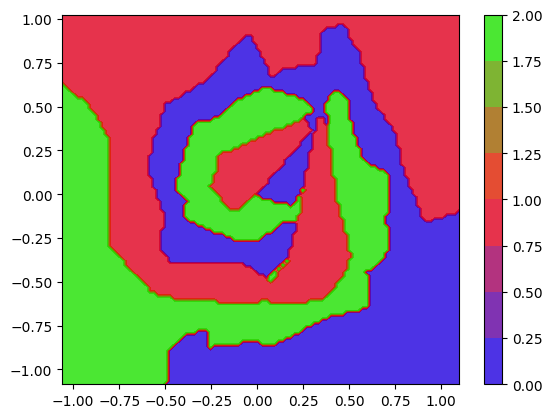

In [18]:
plt.contourf(xx, yy, Z, cmap='brg', alpha=0.8)
plt.colorbar()

**Reasoning**:
Plot the original data points on top of the contour plot to visualize the decision boundary in relation to the actual data.



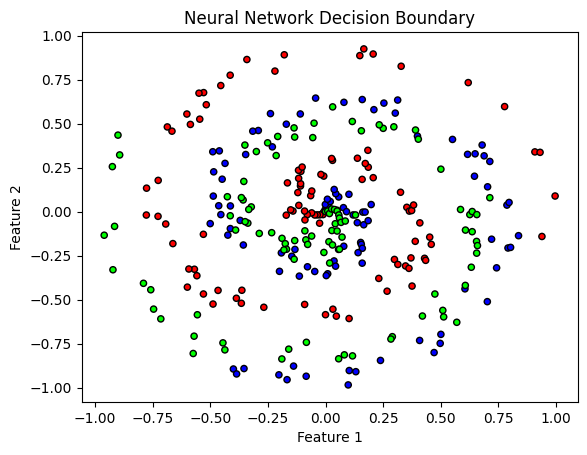

In [19]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', s=20, edgecolors='k')
plt.title('Neural Network Decision Boundary')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

## Overlay the original data points

### Subtask:
Overlay the original training data points on top of the decision boundary visualization to see how well the model separates the classes.


**Reasoning**:
The contour plot of the decision boundary has already been created in the previous step. Now, overlay the original data points on top of this plot to visualize how well the model separates the classes.



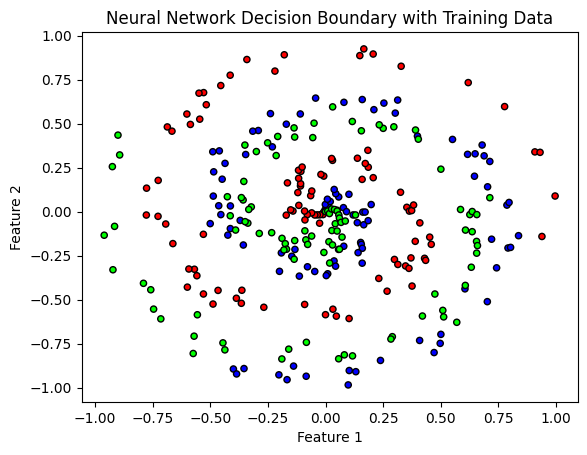

In [20]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg', s=20, edgecolors='k')
plt.title('Neural Network Decision Boundary with Training Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()